In [3]:
from __future__ import print_function
from __future__ import division
import matplotlib.pyplot as plt
from matplotlib import style
import numpy as np
import pandas as pd
import seaborn as sns

style.use('ggplot')
%matplotlib inline

In [4]:
try:
    import gym
except:
    !pip install gym
    import gym
    
isFast = True

In [5]:
import numpy
import math 
import os 
import random

import cntk as C

In [6]:
# Select the right target device when this notebook is being tested:
if 'TEST_DEVICE' in os.environ:
    if os.environ['TEST_DEVICE'] == 'cpu':
        C.device.try_set_default_device(C.device.cpu())
    else:
        C.device.try_set_default_device(C.device.gpu(0))

In [7]:
## environment and setting

STATE_COUNT = 1
ACTION_COUNT = 4

# change these config later

# class Environment:
# 

env = gym.make('CartPole-v0')

STATE_COUNT  = env.observation_space.shape[0]
ACTION_COUNT = env.action_space.n

STATE_COUNT, ACTION_COUNT

[2017-07-19 17:47:51,560] Making new env: CartPole-v0


(4, 2)

In [27]:
a = [1,2,3]
b = [4,5,6]
c = a+b
print(c)

t = [-1] * 64
print(t)

print (a[1:2])

[1, 2, 3, 4, 5, 6]
[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
[2]


In [41]:
# M1~M9, C1~C9, L1~L9, EW,WW,SW,NW, R,G,W, F1~8
# 36,    72,    108    136, 
# action = win + play(34) + eat(3) + pon + gan(34) + pass
    # eat0 = eat downward, ex: eat 5 with 67
    # eat1 = eat middle,   ex: eat 5 with 46
    # eat2 = eat upward    ex: eat 5 with 34

# Feature_From = [0,1,2], 0=self, 1=prevPlayer, 2=from other players
TABLE_STATE_SIZE = 34      # 34 types of card and their quentities (no flowers)
# TABLE_STATE_SIZE = 64    # beacause there is at most 64 card on the table
HAND_STATE_SIZE = 34
OPEN_STATE_SIZE = 42       # 42 = all types including flowers

# state = from + in_card + hand + open + (table)
STATE_COUNT = 1 + 1 + HAND_STATE_SIZE + OPEN_STATE_SIZE + TABLE_STATE_SIZE
ACTION_COUNT = 1 + 34 + 3 + 1 + 34 + 1

class Environment:
    def __init__(self):
        self.cardSet = CardSet()
        self.players = []
        self.cards = []
        self.cards_open = []
        self.table = []
        self.s = []
        self.s_ = []
        self.cur_player_idx = 0
        
        self.reset()
    
    def reset(self):
        # self.table 
        self.table = []
        
        # reset 4 player's hand card
        self.players = []
        self.cards = []
        self.cards_open = []
        for i in range(4):
            self.players.append(Agent())
            self.cards.append([])
            self.cards_open.append([])
            
        # reset card deck
        self.cardSet.reset()
        
        # deal cards
        for i in range(16):
            for j in range(4):
                self.cards[j].append(self.cardSet.draw())
        
        # sorted
        for i in range(4):
            self.cards[i].sort()
            
        # reset pool
        self.pool = []
    
    def render(self):
        print("Deck: \n",cardSet2Str(self.cardSet.cards))
        print("Table: \n", cardSet2Str(self.table))
        for i in range(4):
            print("P%d"%(i), ":", cardSet2Str(self.cards[i]), "\n\t", cardSet2Str(self.cards_open[i]))
    
    def run(self):
        idx = self.cur_player_idx
        
        # 1. Draw and act by idx
        card = self.cardSet.draw()
        # make state for player
        s[idx] = self.makeState(idx, card)
        # cur index player act respond with this s
        a[idx] = self.players[idx].act(s , self.makeLegalList(idx,0,0))
        print("P%d do act %d."%(idx,a[idx]))
        
        self.step(idx, card, a[idx])
        # 2. idx play one card, other player react
        
        # 3. switch to next player
        
        # return observation, reward, done, info
        pass

    def makeLegalList(self, idx, frm=0, canWin=0):
        legal_win = [0]
        legal_play = [0]*34
        legal_eat = [0]*3
        legal_pon = [0]
        legal_gan = [0]*34
        legal_pass = [1]
        if canWin:
            legal_win = [1]
        if frm == 0: 
            for val in self.cards[idx]:
                legal_play[val] = 1
        if frm == 1:
            # check eat
            # check pon
            pass
        if frm == 2:
            # check pon
            # check gan
            pass
            
        # action = win + play(34) + eat(3) + pon + gan(34) + pass
        legal_action_list = legal_win + legal_play + legal_eat + legal_pon + legal_gan + legal_pass
        return legal_action_list
        
    
    def step(self, idx, card, action): 
        # action = win + play(34) + eat(3) + pon + gan(34)
            # eat0 = eat downward, ex: eat 5 with 67
            # eat1 = eat middle,   ex: eat 5 with 46
            # eat2 = eat upward    ex: eat 5 with 34
        if action < 0:
            # error
            print("Error, action should >= 0")
            return
        if action == 0:
            # win check
            print("win")
            return
        if action <= 34:
            # play card with responding index
            print("play", cardID2Str(action-1))
            return
        if action <= 37:
            new_action = action - 34
            # 3 type of eat
            print("eat")
            return
        if action == 38:
            # pon
            print("pon")
            return
        if action <= 72:
            new_action = action - 38
            # gan with responding index
            print("gan")
            return
        if action == 73:
            # pass the card (if you're curplaying player, you can/cannot pass, bigyo is still comtemplate)
            print("pass")
            return
    
    def makeState(self, idx, card, featureFrom=0):
        # state = from + in_card + hand + open + (table)
        hand = self.encodeCards(self.cards[idx])
        cards_open = self.encodeCards(self.cards_open[idx], 42)  # cards which are opened
        table = self.encodeCards(self.table)
        
        state = [featureFrom] + [card] + hand + cards_open + table 
        if not len(state) == STATE_COUNT:
            print("ERROR: state len wrong !! len(state) = %d, STATE_COUNT = %d"%(len(state), STATE_COUNT))
        
        return state
    
    def encodeCards(self, cards, num=34):
        enc = [0] * num
        for card in cards:
            enc[card] += 1
        return enc
        

env = Environment()
    
env.render()

s =  env.makeState(0, env.cardSet.draw())
print("make state = ", s, ", len = %d"%(len(s)))

env.run()

env.render()

Deck: 
 ['M3', 'M2', 'L8', 'L6', 'C6', 'L9', 'L7', 'L2', 'C3', 'C7', 'C4', 'L2', 'M7', 'L7', 'M9', 'C8', 'C9', 'C2', 'M8', 'L7', 'C3', 'L1', 'RC', 'M8', 'NW', 'L8', 'EW', 'L4', 'EW', 'M4', 'M3', 'RC', 'L5', 'C5', 'GF', 'M6', 'SW', 'C4', 'NW', 'L2', 'M2', 'L1', 'L9', 'L8', 'M4', 'M5', 'C6', 'M1', 'C1', 'C4', 'M3', 'M6', 'L6', 'M5', 'C4', 'L4', 'L1', 'M2', 'WW', 'M4', 'M7', 'NW', 'C9', 'C3', 'WB', 'M2', 'C5', 'C8', 'EW', 'M1', 'C9', 'M9', 'C6', 'L4', 'C3', 'C2', 'C9', 'L6', 'M5', 'C7']
Table: 
 []
P0 : ['M1', 'M1', 'M2', 'M6', 'M7', 'M7', 'C5', 'C6', 'C7', 'C8', 'L2', 'L5', 'EW', 'SW', 'SW', 'GF'] 
	 []
P1 : ['M1', 'M5', 'M5', 'M6', 'M9', 'C1', 'C1', 'C2', 'C5', 'L3', 'L6', 'L7', 'L8', 'L9', 'GF', 'WB'] 
	 []
P2 : ['M3', 'M4', 'M7', 'M8', 'M8', 'C7', 'C8', 'L3', 'L3', 'L4', 'L5', 'WW', 'WW', 'NW', 'RC', 'WB'] 
	 []
P3 : ['M3', 'M4', 'M6', 'M8', 'M9', 'C1', 'C2', 'L1', 'L3', 'L5', 'L9', 'WW', 'SW', 'RC', 'GF', 'WB'] 
	 []
make state =  [0, 2, 2, 1, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 1, 1, 1

In [16]:
class CardSet:
    def __init__(self):
        self.cards = []
        self.reset()
        
    def reset(self):
        self.cards = []
        for i in range(144):
            self.cards.append( self.cardIDcompress(i) )
        self.shuffle() 
        
    def cardIDcompress(self, idx):
        if idx < 0:
            print ("id should be larger than or equal to 0")
        if idx < 136:
            return int(idx/4)
        elif idx < 144:
            return int(idx-136)
        else:
            print ("id should be less than 144")
        return -1 # error
    
    def draw(self, direction="front"):
        if self.canDraw() == False:
            print("can't draw anymore")
            return -1
            
        if direction == "front":    
            card = self.cards[0]
            self.cards = self.cards[1:]
        elif direction == "back":
            card = self.cards[len(self.cards)-1]
            self.cards = self.cards[:-1]
        else:
            print("direction should be (front) or (back)")
            return -1
            
        return card
    
    def canDraw(self):
        if self.cardRemain() <= 0:
            return False
        return True
    
    def cardRemain(self):
        return len(self.cards)
    
    def shuffle(self):
        cardN = self.cardRemain()
        for i in range(cardN):
            idx = random.randint(i, cardN-1)
            temp = self.cards[i]
            self.cards[i] = self.cards[idx]
            self.cards[idx] = temp

In [17]:
# M1~M9, C1~C9, L1~L9, EW,WW,SW,NW, R,G,W, F1~8
# 9,    18,    27    24, 

def cardID2Str(idx):
    if idx < 0:
        print ("id should be larger than or equal to 0")
    if idx < 27:
        card_num = int(idx%9) + 1
        card_type = int(idx/9)
        card_type_list = ["M", "C", "L"]
        return card_type_list[card_type] + str(card_num)
    elif idx < 34:
        card_type = int(idx-27)
        card_type_list = ["EW","WW","SW","NW", "RC","GF","WB"]
        return card_type_list[card_type]
    elif idx < 42:
        card_num = int((idx-34))+1
        return "F"+ str(card_num)
        pass
    else:
        print ("id should be less than 144")
        
    return -1

def cardSet2Str(cards):
    cards_str = []
    for i in range(len(cards)):
        cards_str.append(cardID2Str(cards[i]))
    return cards_str

cards = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
print(cardSet2Str(cards))

['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7']


In [18]:

H = 64 # hidden layer size

class Brain:
    def __init__(self):
        self.params = {}
        self.model, self.trainer, self.loss = self._create()
        
    def _create(self):
        observation = C.sequence.input_variable(STATE_COUNT, np.float32, name="s")
        q_target = C.sequence.input_variable(ACTION_COUNT, np.float32, name="q")
        
        # Following a style similar to Keras
        l1 = C.layers.Dense(H, activation=C.relu)
        l2 = C.layers.Dense(ACTION_COUNT)
        unbound_model = C.layers.Sequential([l1,l2])
        model = unbound_model(observation)
        
        self.params = dict(W1=l1.W, b1=l1.b, W2=l2.W, b2=l2.b)
        
        # loss = 'mse'
        loss = C.reduce_mean(C.square(model - q_target), axis=0)
        meas = C.reduce_mean(C.square(model - q_target), axis=0)
        
        # optimizer
        lr = 0.00025
        lr_schedule = C.learning_rate_schedule(lr, C.UnitType.minibatch)
        learner = C.sgd(model.parameters, lr_schedule, gradient_clipping_threshold_per_sample=10)
        trainer = C.Trainer(model,(loss,meas),learner)
        
        # CNTK: return trainer and loss as well
        return model, trainer, loss

    def train(self, x, y, epoch=1, verbose=0):
        arguments = dict(zip(self.loss.arguments, [x,y]))
        updated, results = self.trainer.train_minibatch(arguments, outputs = [self.loss.output])
        
    def predict(self, s):
        return self.model.eval([s])


In [19]:
class Memory:  # stored as (s, a, r, s_ )
    samples = []
    
    def __init__(self, capacity):
        self.capacity = capacity
        
    def add(self, sample):
        self.samples.append(sample)
        
        if len(self.samples) > self.capacity:
            self.samples.pop(0)
            
    def sample(self, n):
        n = min(n, len(self.samples))
        return random.sample(self.samples, n)

In [13]:
MEMORY_CAPACITY = 100000
BATCH_SIZE = 64

GAMMA = 0.99 # discount factor

MAX_EPSILON = 1
MIN_EPSILON = 0.01 # stay a bit curious even when getting old
LAMBDA = 0.0001    # speed of decay 

class Agent:
    steps = 0
    epsilon = MAX_EPSILON
    
    def __init__(self):
        self.brain = Brain()
        self.memory = Memory(MEMORY_CAPACITY)
        
    def act(self, s, legal_action=[1]*ACTION_COUNT):
        if random.random() < self.epsilon:
            legal_index_list = []
            for index, value in enumerate(legal_action):
                if value == 1:
                    legal_index_list.append(index)
            return random.choice(legal_index_list)
        else:
            # return numpy.argmax(self.brain.predict(s))
            return numpy.argmax( np.array(self.brain.predict(s)) * np.array(legal_action) )
        
    def observe(self, sample): # in (s, a, r, s_) format
        self.memory.add(sample)
        
        # slowly decrease Epsilon based on our experience
        self.steps += 1
        self.epsilon = MIN_EPSILON + (MAX_EPSILON - MIN_EPSILON) * math.exp(-LAMBDA * self.steps)
        
    def replay(self):
        batch = self.memory.sample(BATCH_SIZE)
        batchLen = len(batch)
        
        no_state = numpy.zeros(STATE_COUNT)
        
        # CNTK: explicity setting to float32
        states = numpy.array([ o[0] for o in batch ], dtype = np.float32)
        states_ = numpy.array([(no_state if o[3] is None else o[3]) for o in batch ] , dtype = np.float32)
        
        p = agent.brain.predict(states)
        p_ = agent.brain.predict(states_)
        
        # CNTK: explicitly setting to float32
        x = numpy.zeros((batchLen, STATE_COUNT)).astype(np.float32)
        y = numpy.zeros((batchLen, ACTION_COUNT)).astype(np.float32)
        
        for i in range(batchLen):
            s, a, r, s_ = batch[i]
            
            # CNTK:[0] beacuse of sequence dimension
            t = p[0][i]
            if s_ is None:
                t[a] = r
            else:
                t[a] = r + GAMMA * numpy.amax(p_[0][i])
                
            x[i] = s
            y[i] = t
        
        self.brain.train(x,y)

In [17]:
def plot_weights(weights, figsize=(7,5)):
    '''Heat map of weights to see which neurons play which role'''
    sns.set(style="white")
    f, ax = plt.subplots(len(weights), figsize=figsize)
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    
    for i, data in enumerate(weights):
        axi = ax if len(weights)==1 else ax[i]
        if isinstance(data, tuple):
            w, title = data
            axi.set_title(title)
        else:
            w = data
                
        sns.heatmap(w.asarray(), cmap=cmap, square=True, center=True, #annot=True,
                    linewidths=.5, cbar_kws={"shrink": .25}, ax=axi)

Episode: 20, Average reward for episode 23.550000.
Episode: 40, Average reward for episode 21.850000.
Episode: 60, Average reward for episode 21.600000.
Episode: 80, Average reward for episode 16.250000.
Episode: 100, Average reward for episode 19.000000.
Episode: 120, Average reward for episode 14.300000.
Episode: 140, Average reward for episode 16.550000.
Episode: 160, Average reward for episode 14.800000.
Episode: 180, Average reward for episode 14.400000.
Episode: 200, Average reward for episode 17.000000.
Episode: 220, Average reward for episode 18.200000.
Episode: 240, Average reward for episode 14.550000.
Episode: 260, Average reward for episode 14.500000.
Episode: 280, Average reward for episode 13.200000.
Episode: 300, Average reward for episode 13.050000.
Episode: 320, Average reward for episode 13.350000.
Episode: 340, Average reward for episode 15.350000.
Episode: 360, Average reward for episode 14.450000.
Episode: 380, Average reward for episode 13.750000.
Episode: 400, Av

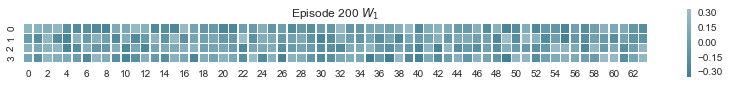

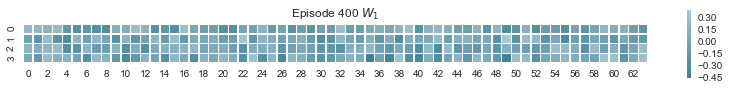

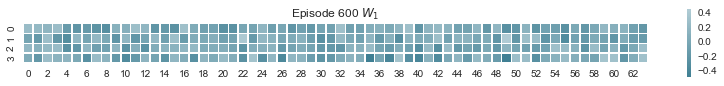

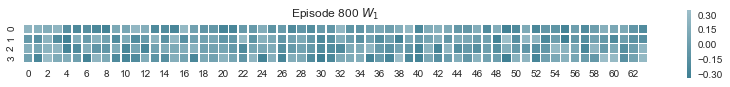

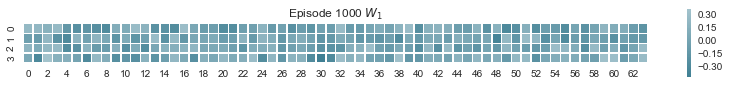

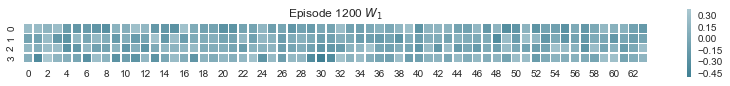

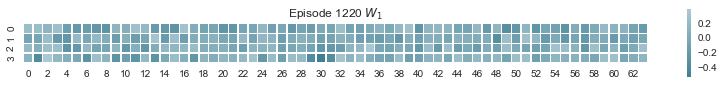

In [13]:
REWARD_TARGET = 30 if isFast else 200
BATCH_SIZE_BASELINE = 20 if isFast else 50

TOTAL_EPISODES = 2000 if isFast else 3000

def run(agent):
    s = env.reset()
    R = 0

    while True:
        # Uncomment the line below to visualize the cartpole
#         env.render()

        # CNTK: explicitly setting to float32
        a = agent.act(s.astype(np.float32))

        s_, r, done, info = env.step(a)

        if done: # terminal state
            s_ = None

        agent.observe((s, a, r, s_))
        agent.replay()

        s = s_
        R += r

        if done:
            return R

agent = Agent()

episode_number = 0
reward_sum = 0
while episode_number < TOTAL_EPISODES:
    reward_sum += run(agent)
    episode_number += 1
    if episode_number % BATCH_SIZE_BASELINE == 0:
        print('Episode: %d, Average reward for episode %f.' % (episode_number,
                                                               reward_sum / BATCH_SIZE_BASELINE))
        if episode_number%200==0:
            plot_weights([(agent.brain.params['W1'], 'Episode %i $W_1$'%episode_number)], figsize=(14,5))
        if reward_sum / BATCH_SIZE_BASELINE > REWARD_TARGET:
            print('Task solved in %d episodes' % episode_number)
            plot_weights([(agent.brain.params['W1'], 'Episode %i $W_1$'%episode_number)], figsize=(14,5))
            break
        reward_sum = 0
agent.brain.model.save('dqn.mod')

In [14]:
# b = Brain()
# b.model.load("dqn.mod")
# x = np.array([1,1,1,1], np.float32)
# p = b.predict(x)
# p

# test load model

In [15]:
env = gym.make('CartPole-v0')

num_episodes = 10  # number of episodes to run

modelPath = 'dqn.mod'
root = C.load_model(modelPath)

for i_episode in range(num_episodes):
    print(i_episode)
    observation = env.reset()  # reset environment for new episode
    done = False
    while not done: 
        if not 'TEST_DEVICE' in os.environ:
#             env.render()
        action = np.argmax(root.eval([observation.astype(np.float32)]))
        observation, reward, done, info  = env.step(action) 

[2017-07-19 11:52:21,696] Making new env: CartPole-v0


0
1
2
3
4
5
6
7
8
9


In [11]:
# C1~C9, M1~M9, L1~L9, F1~8, EW,WW,SW,NW, R,G,W
# state = in + hand + open + (table)
# action = win + play(0~16) + eat(0~2) + pon + gan

# legal_act(state) -> [bool(len(action))]

player = []
for i in range(4):
    player.append(Agent())
    
print(player)

1 4
1 4
1 4
1 4
[<__main__.Agent object at 0x000001D3B5E547F0>, <__main__.Agent object at 0x000001D3B5E54D68>, <__main__.Agent object at 0x000001D3B5E54908>, <__main__.Agent object at 0x000001D3B5E54B70>]
